In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import numpy as np
from tqdm import tqdm
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:

train_images_dir = '/content/drive/MyDrive/train/images'
train_masks_dir = '/content/drive/MyDrive/train/masks'
test_images_dir = '/content/drive/MyDrive/test/images'
test_masks_dir = '/content/drive/MyDrive/test/masks'

In [3]:
def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

In [5]:
def build_unet_model():
   inputs = layers.Input(shape=(128,128,3))
   f1, p1 = downsample_block(inputs, 64)
   f2, p2 = downsample_block(p1, 128)
   f3, p3 = downsample_block(p2, 256)
   f4, p4 = downsample_block(p3, 512)

   bottleneck = double_conv_block(p4, 1024)

   u6 = upsample_block(bottleneck, f4, 512)
   u7 = upsample_block(u6, f3, 256)
   u8 = upsample_block(u7, f2, 128)
   u9 = upsample_block(u8, f1, 64)

   outputs = layers.Conv2D(1, 1, padding="same", activation = "softmax")(u9)

   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model


In [6]:
def dice_coefficient(y_true, y_pred):
  smooth = 1e-6  # Smoothing factor to avoid division by zero
  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
  dice = (2. * intersection + smooth) / (union + smooth)
  return dice

def iou(y_true, y_pred):
  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
  smooth = 1e-6  # Smoothing factor to avoid division by zero
  return (intersection + smooth) / (union - intersection + smooth)

def precision(y_true, y_pred):
  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
  smooth = 1e-6  # Smoothing factor to avoid division by zero
  return (intersection + smooth) / (tf.reduce_sum(y_pred)+ smooth)

def recall(y_true, y_pred):
  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
  smooth = 1e-6  # Smoothing factor to avoid division by zero
  return (intersection + smooth) / (tf.reduce_sum(y_true)+ smooth)


In [7]:
unet_model = build_unet_model()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=["accuracy", dice_coefficient, iou, precision, recall])

In [8]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 255
   return input_image, input_mask

In [9]:
def load_image_and_mask(image_file, mask_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    mask = tf.io.read_file(mask_file)
    mask = tf.image.decode_png(mask, channels=1)
    return image, mask

def load_image_train(image_file, mask_file):
    input_image, input_mask = load_image_and_mask(image_file, mask_file)
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(image_file, mask_file):
    input_image, input_mask = load_image_and_mask(image_file, mask_file)
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [10]:
train_image_files = sorted([os.path.join(train_images_dir, filename) for filename in os.listdir(train_images_dir)])
train_mask_files = sorted([os.path.join(train_masks_dir, filename) for filename in os.listdir(train_masks_dir)])
test_image_files = sorted([os.path.join(test_images_dir, filename) for filename in os.listdir(test_images_dir)])
test_mask_files = sorted([os.path.join(test_masks_dir, filename) for filename in os.listdir(test_masks_dir)])

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_files, train_mask_files))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
# train_dataset = train_dataset.take(200)  # Limit to first 200 samples for training

test_dataset = tf.data.Dataset.from_tensor_slices((test_image_files, test_mask_files))
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
# test_dataset = test_dataset.take(20)  # Limit to first 20 samples for testing

print("Number of training samples:", len(train_image_files))
print("Number of testing samples:", len(test_image_files))

Number of training samples: 820
Number of testing samples: 382


In [11]:
BATCH_SIZE = 4
BUFFER_SIZE = 100
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

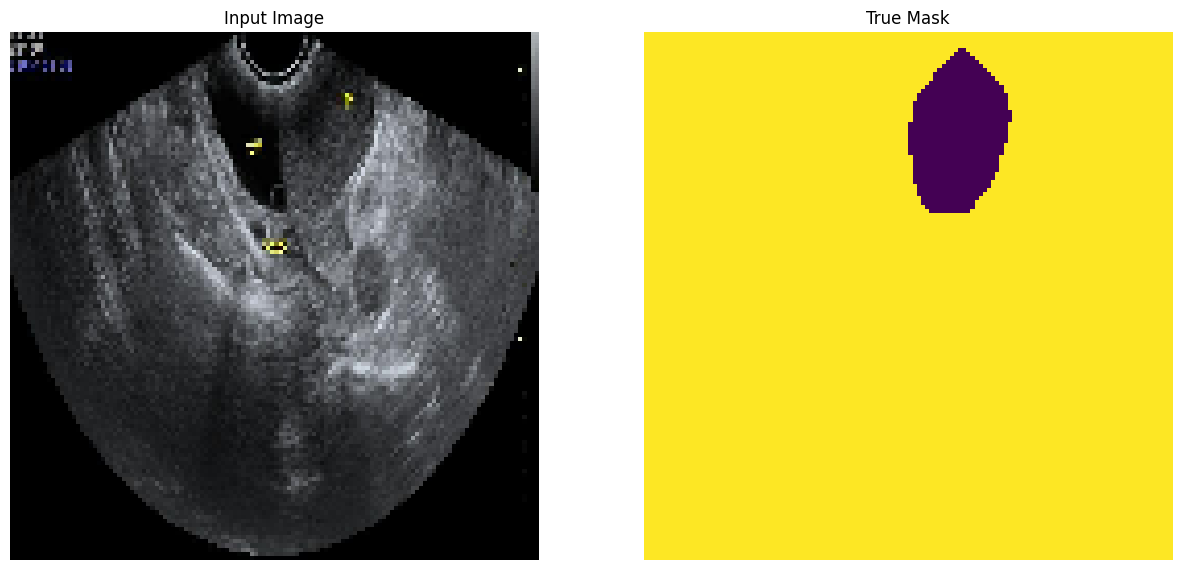

In [12]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])
# print(tf.unique(tf.reshape(sample_mask, [-1])))

In [17]:
NUM_EPOCHS = 20
TRAIN_LENGTH = len(train_image_files)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = len(test_image_files)
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

In [18]:
unet_model.save("unet_model.h5")

1/1 [==============================] - 2s 2s/step


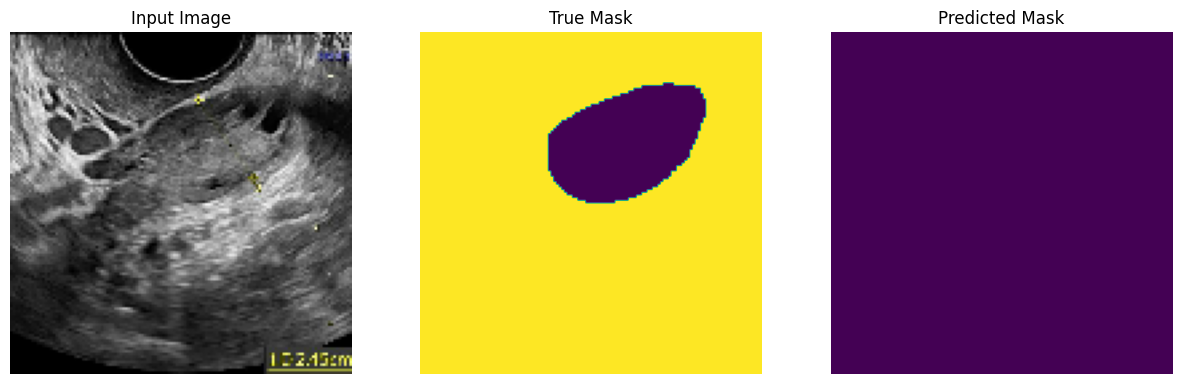

In [15]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
sample_image_batch = np.expand_dims(sample_image, axis=0)
pred = unet_model.predict(sample_image_batch)
image = np.squeeze(pred, axis=0)
display([sample_image, sample_mask, image])

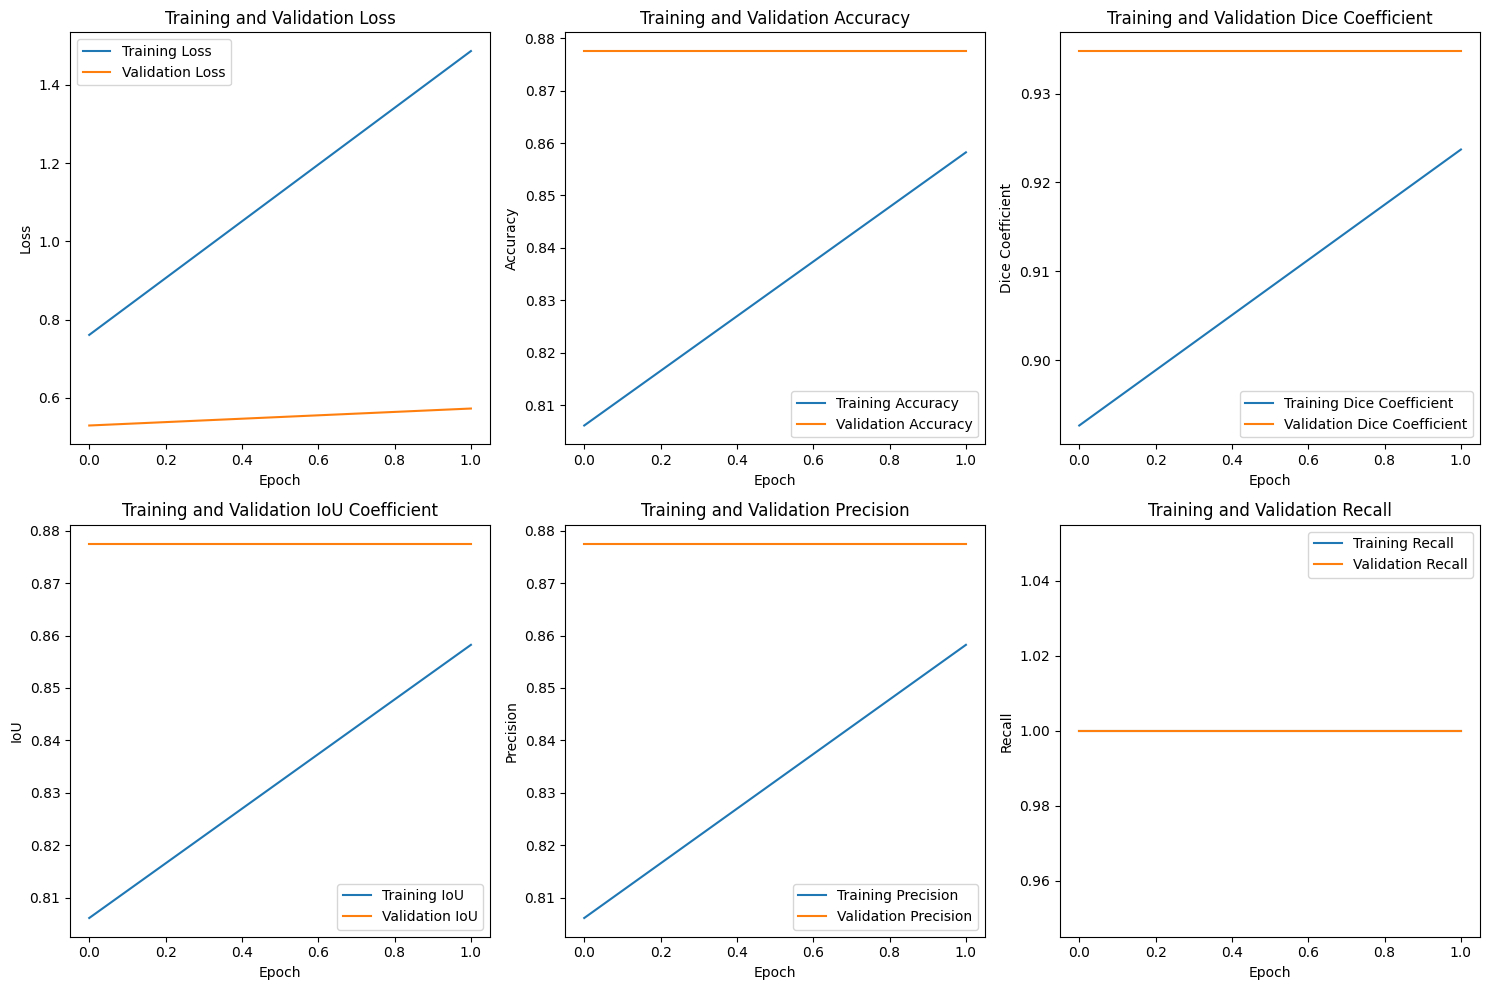

In [16]:
def plot_metrics(history):
    # Extract metrics from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    dice_coefficient = history.history['dice_coefficient']
    val_dice_coefficient = history.history['val_dice_coefficient']
    iou = history.history['iou']
    val_iou = history.history['val_iou']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']

    # Plot loss, accuracy, dice coefficient, IoU, precision, and recall
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    axs[0, 0].plot(loss, label='Training Loss')
    axs[0, 0].plot(val_loss, label='Validation Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].set_title('Training and Validation Loss')
    axs[0, 0].legend()

    axs[0, 1].plot(accuracy, label='Training Accuracy')
    axs[0, 1].plot(val_accuracy, label='Validation Accuracy')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].set_title('Training and Validation Accuracy')
    axs[0, 1].legend()

    axs[0, 2].plot(dice_coefficient, label='Training Dice Coefficient')
    axs[0, 2].plot(val_dice_coefficient, label='Validation Dice Coefficient')
    axs[0, 2].set_xlabel('Epoch')
    axs[0, 2].set_ylabel('Dice Coefficient')
    axs[0, 2].set_title('Training and Validation Dice Coefficient')
    axs[0, 2].legend()

    axs[1, 0].plot(iou, label='Training IoU')
    axs[1, 0].plot(val_iou, label='Validation IoU')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('IoU')
    axs[1, 0].set_title('Training and Validation IoU Coefficient')
    axs[1, 0].legend()

    axs[1, 1].plot(precision, label='Training Precision')
    axs[1, 1].plot(val_precision, label='Validation Precision')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Precision')
    axs[1, 1].set_title('Training and Validation Precision')
    axs[1, 1].legend()

    axs[1, 2].plot(recall, label='Training Recall')
    axs[1, 2].plot(val_recall, label='Validation Recall')
    axs[1, 2].set_xlabel('Epoch')
    axs[1, 2].set_ylabel('Recall')
    axs[1, 2].set_title('Training and Validation Recall')
    axs[1, 2].legend()

    plt.tight_layout()

    plt.savefig("metrics.png")
    plt.show()


# Assuming model_history contains your training history
plot_metrics(model_history)
